In [66]:
import os
import re
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as sio
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
warnings.simplefilter(action='ignore', category=FutureWarning)

In [67]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

In [68]:
def extract_numeric(value):
    """
    Extract numeric part from a string. Returns float if successful, else returns None.
    """
    if isinstance(value, (int, float)):
        return float(value)
    elif isinstance(value, str):
        # Use regex to extract numbers from the string
        match = re.search(r'[\d.]+', value)
        if match:
            return float(match.group(0))
    return None  # Return None if no numeric value is found

def process_subfolders(main_folder, div, sheet_path, sheet_name='ridges', frame_interval_range=None, resolution_range=None):
    """
    Function to load CSVs from subfolders and match them with details from an Excel sheet.
    Args:
    - main_folder: Main directory path containing subfolders with CSV files.
    - div: The 'div' value to filter the Excel sheet.
    - sheet_path: Path to the Excel sheet containing imaging details.
    - sheet_name: The sheet name in the Excel file (default: 'ridges').
    - resolution_range: Tuple (min_resolution, max_resolution) to filter by resolution.
    - frame_interval_range: Tuple (min_interval, max_interval) to filter by frame interval.

    Returns:
    - dataframes: A dictionary of loaded dataframes, keyed by subfolder names.
    - subfolder_names: A list of subfolder names that contain CSV files.
    - frame_intervals: A list of frame intervals.
    - resolutions: A list of resolution values.
    - timepoints: A list of timepoints.
    - neural_mask_paths: A list of paths to the 'neural_mask.mat' files.
    """
    
    df_sheet = pd.read_excel(sheet_path, sheet_name=sheet_name)
    df_sheet_filtered = df_sheet[df_sheet['div'] == div]  # Filter by 'div'
    
    # Initialize containers
    dataframes = {}
    subfolder_names = []
    frame_intervals = []
    resolutions = []
    timepoints = []
    neural_mask_paths = []

    skipped_folders = []
    ind = 0

    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        if os.path.isdir(subfolder_path):
            # Only look for tp_trajectories_final.csv
            csv_file_traj = os.path.join(subfolder_path, 'tp_trajectories_final.csv')
            mat_file = os.path.join(subfolder_path, 'neural_mask.mat')
            
            if os.path.isfile(csv_file_traj):
                for value in df_sheet_filtered['file name']:
                    if value in subfolder:
                        index = df_sheet_filtered.index[df_sheet_filtered['file name'] == value].tolist()
                        
                        if index:
                            # Extract frame interval and resolution
                            interval = df_sheet_filtered['frame interval'][index].values[0]
                            integer_interval_value = extract_numeric(interval)
                            resolution = df_sheet_filtered['resolution'][index].values[0]
                            integer_resolution_value = extract_numeric(resolution)
                            
                            # Check if within the specified ranges
                            if ((resolution_range is None or integer_resolution_value is None or (resolution_range[0] <= integer_resolution_value <= resolution_range[1])) and
                                (frame_interval_range is None or integer_interval_value is None or (frame_interval_range[0] <= integer_interval_value <= frame_interval_range[1]))):
                                
                                # Load the CSV
                                df_traj = pd.read_csv(csv_file_traj)
                                
                                dataframes[subfolder] = {
                                    'tp_trajectories_final': df_traj
                                }
                                subfolder_names.append(subfolder)
                                frame_intervals.append(integer_interval_value)
                                resolutions.append(integer_resolution_value)
                                timepoints.append(df_sheet_filtered['# timepoints'][index].values[0])
                                neural_mask_paths.append(mat_file if os.path.isfile(mat_file) else None)
                                ind += 1
                                break
                            else:
                                skipped_folders.append({
                                    'folder': subfolder,
                                    'frame_interval': integer_interval_value,
                                    'resolution': integer_resolution_value
                                })
                                break
                                
    print(f"{ind} subfolders loaded successfully.")
    print(f"{len(skipped_folders)} subfolders skipped:")
    for skipped in skipped_folders:
        print(f"Folder: {skipped['folder']}, Frame Interval: {skipped['frame_interval'] or 'None'}, Resolution: {skipped['resolution'] or 'None'}")

    return dataframes, subfolder_names, frame_intervals, resolutions, timepoints, neural_mask_paths


In [69]:
frame_interval = [1.8,2.2]
resolution = [2.6,2.9]

## DIV2 
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges\div2'   # Specify the main folder 
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'  # Path to the Excel file
dataframes2, subfolder_names2, frame_intervals2, resolutions2, timepoints2, neural2 = process_subfolders(main_folder, div=2, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)

## DIV3 
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges\div3'   
dataframes3, subfolder_names3, frame_intervals3, resolutions3, timepoints3, neural3 = process_subfolders(main_folder, div=3, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)

## DIV7
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges\div7'   
dataframes7, subfolder_names7, frame_intervals7, resolutions7, timepoints7, neural7 = process_subfolders(main_folder, div=7, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)

## DIV8
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges\div8'   
dataframes8, subfolder_names8, frame_intervals8, resolutions8, timepoints8, neural8 = process_subfolders(main_folder, div=8, sheet_path=sheet_path, frame_interval_range=frame_interval, resolution_range=resolution)


7 subfolders loaded successfully.
0 subfolders skipped:
1 subfolders loaded successfully.
2 subfolders skipped:
Folder: ridges_2021_04_16_MAX_well2_timelapse2_PFS, Frame Interval: 6.0, Resolution: 2.7778
Folder: ridges_2021_04_16_MAX_well2_timelapse3_PFS, Frame Interval: 10.0, Resolution: 2.7778
3 subfolders loaded successfully.
3 subfolders skipped:
Folder: ridges_2021_04_16_MAX_well1_div7ridges_timelapse1, Frame Interval: 6.30135, Resolution: 2.7778
Folder: ridges_2021_04_16_MAX_well1_div7ridges_timelapse2, Frame Interval: 0.06623, Resolution: 2.7778
Folder: ridges_2021_04_16_MAX_well1_div7ridges_timelapse4, Frame Interval: 0.06626, Resolution: 2.7778
3 subfolders loaded successfully.
0 subfolders skipped:


## Data Merge

In [70]:
# Combine DIV2 and DIV3 results into 'early-stage results'
early_stage_dataframes = {**dataframes2, **dataframes3}
early_stage_subfolder_names = subfolder_names2 + subfolder_names3
early_stage_frame_intervals = frame_intervals2 + frame_intervals3
early_stage_resolutions = resolutions2 + resolutions3
early_stage_timepoints = timepoints2 + timepoints3
early_stage_neural = neural2 + neural3

# Combine DIV7 and DIV8 results into 'mid-stage results'
mid_stage_dataframes = {**dataframes7, **dataframes8}
mid_stage_subfolder_names = subfolder_names7 + subfolder_names8
mid_stage_frame_intervals = frame_intervals7 + frame_intervals8
mid_stage_resolutions = resolutions7 + resolutions8
mid_stage_timepoints = timepoints7 + timepoints8
mid_stage_neural = neural7 + neural8


In [71]:
def calculate_metrics(subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural_mask_paths):
    """
    Calculate metrics for each subfolder based on trajectory properties.

    Args:
    - subfolder_names: List of subfolder names containing data.
    - dataframes: Dictionary of dataframes keyed by subfolder names.
    - frame_intervals: List of frame intervals corresponding to the subfolders.
    - resolutions: List of resolution values corresponding to the subfolders.
    - timepoints: List of timepoints corresponding to the subfolders.
    - neural_mask_paths: List of paths to the 'neural_mask.mat' files corresponding to the subfolders.

    Returns:
    - results_df: A pandas DataFrame containing calculated metrics.
    """

    # Initialize an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['subfolder_name', 'duration_div', 'length_div', 'distance_div', 'n_tracks_norm', 'avg_vel_div'])

    # Loop over all subfolders (movies)
    for i in range(len(subfolder_names)):
        subfolder_name = subfolder_names[i]
        df_traj = dataframes[subfolder_name]['tp_trajectories_final']  # Access the single CSV file with filtered trajectories

        # Get specific values for frame interval, resolution, and timepoints
        frame_interval_for_subfolder = frame_intervals[i]
        resolution_for_subfolder = resolutions[i]
        timepoints_for_subfolder = timepoints[i]

        # Load the neural_mask.mat file if it exists
        neural_mask_file = neural_mask_paths[i]
        neural_mask_data = sio.loadmat(neural_mask_file) if neural_mask_file else {'neural_mask': 1}  # Default to 1 if no file

        # Extract the mask value
        mask_value = neural_mask_data.get('neural_mask', 1)  # Default to 1 to avoid division by zero

        # Calculate the required metrics using df_traj
        duration_div = np.nanmean(df_traj['track_duration'] * frame_interval_for_subfolder)  # Duration in seconds
        distance_div = np.nanmean(df_traj['distance'] / resolution_for_subfolder)  # Distance normalized by resolution
        length_div = np.nanmean(df_traj['track_length'] / resolution_for_subfolder)  # Length normalized by resolution

        # Normalized number of tracks (tracks per minute)
        n_tracks_div = len(df_traj['track_duration'])
        n_tracks_norm = 100 * (n_tracks_div / (timepoints_for_subfolder * frame_interval_for_subfolder / 60)) / np.nansum(mask_value) if timepoints_for_subfolder > 0 else 0

        # Calculate average velocity
        avg_vel_div = np.nanmean(df_traj['avg_inst_velocity'] * 60 / (resolution_for_subfolder * frame_interval_for_subfolder))

        # Create a dictionary for the new row
        new_row = {
            'subfolder_name': subfolder_name,
            'duration_div': duration_div,
            'length_div': length_div,
            'distance_div': distance_div,
            'n_tracks_norm': n_tracks_norm,  # Use normalized tracks
            'avg_vel_div': avg_vel_div,
        }

        # Remove any all-NA or empty values before concatenation
        clean_row = pd.DataFrame([new_row]).dropna(how='all')

        # Concatenate the new row to the results dataframe
        if not clean_row.empty:
            results_df = pd.concat([results_df, clean_row], ignore_index=True)

    return results_df


In [72]:
# Define the necessary parameters for each DIV
# For early stage
results_df_early_stage = calculate_metrics(early_stage_subfolder_names, early_stage_dataframes, early_stage_frame_intervals, early_stage_resolutions, early_stage_timepoints, early_stage_neural)

# For mid stage 
results_df_mid_stage = calculate_metrics(mid_stage_subfolder_names, mid_stage_dataframes, mid_stage_frame_intervals, mid_stage_resolutions, mid_stage_timepoints, mid_stage_neural)

# Optionally, save the resulting dataframes to CSV files
results_df_early_stage.to_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\early_stage_results.csv'), index=False)
results_df_mid_stage.to_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\mid_stage_results.csv'), index=False)


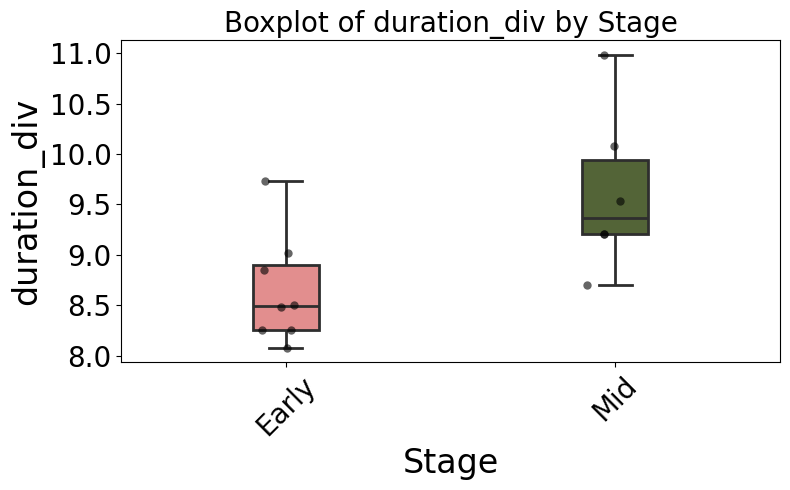

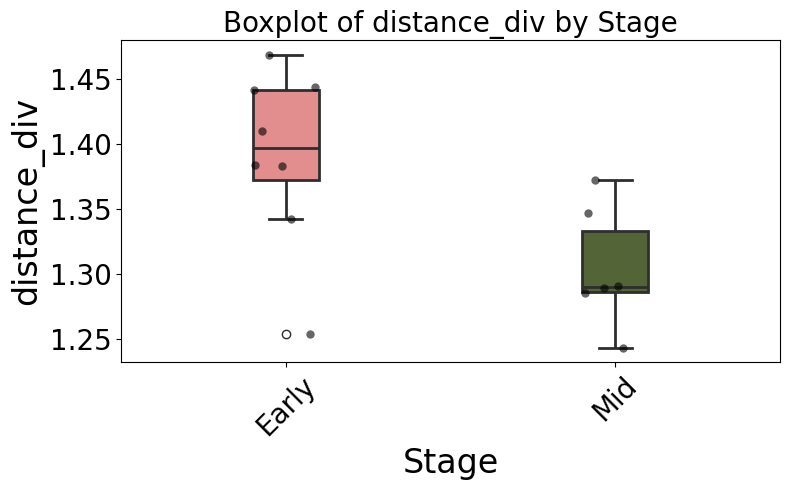

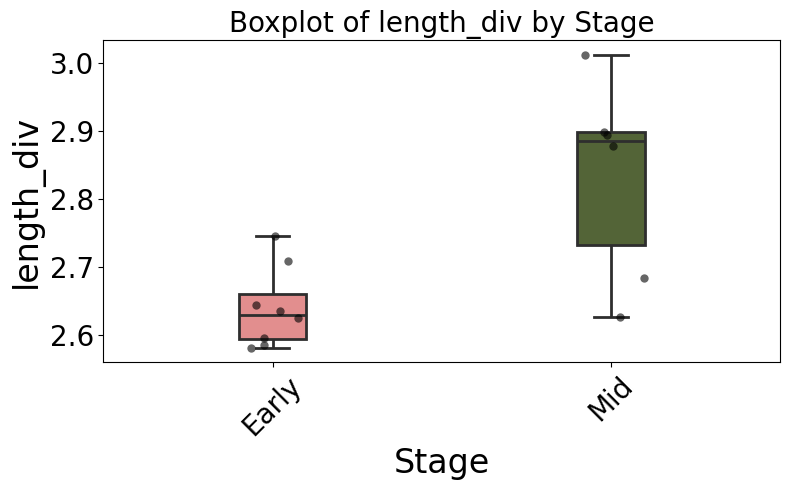

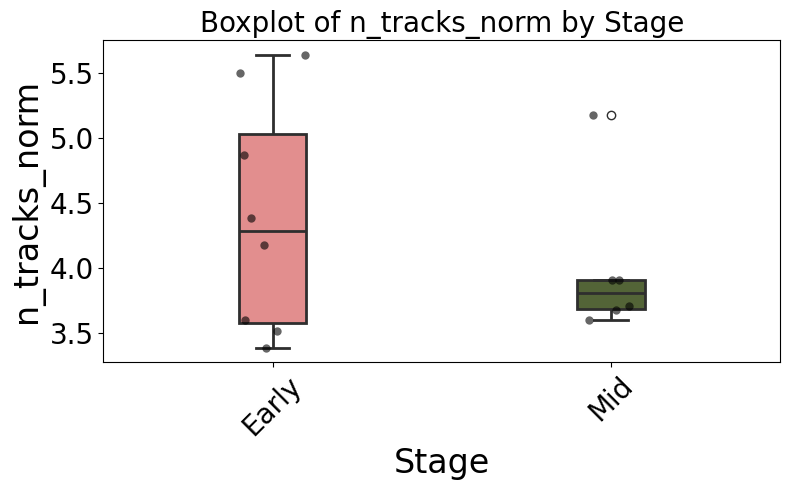

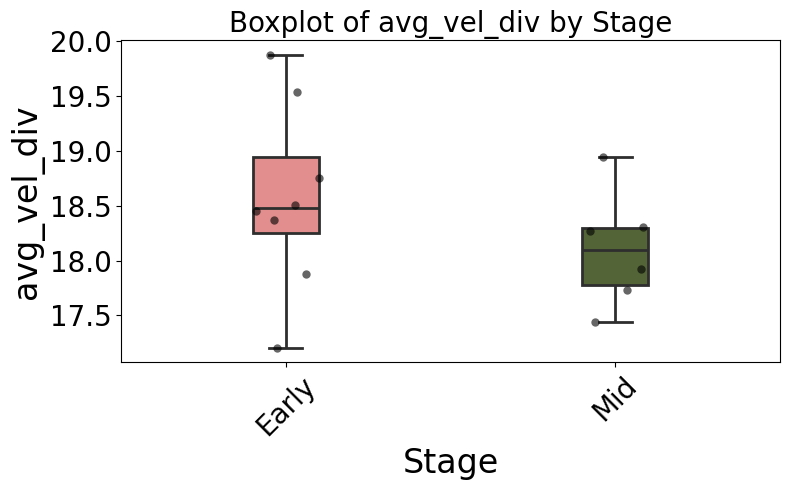

In [73]:
# Load results dataframes for early-stage and mid-stage (adjust the paths as necessary)
results_df_early_stage = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\early_stage_results.csv'))
results_df_mid_stage = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\mid_stage_results.csv'))

# Combine the results into a single DataFrame for plotting
results_combined = pd.concat([
    results_df_early_stage.assign(Stage='Early'),
    results_df_mid_stage.assign(Stage='Mid')
])

# List of metrics to plot
metrics = ['duration_div', 'distance_div', 'length_div', 'n_tracks_norm', 'avg_vel_div']
results_ttests = {}

# Define colors for each stage
stage_colors = {
    'Early': 'lightcoral',
    'Mid': 'darkolivegreen'
}

# Create separate figures for each metric
for metric in metrics:
    plt.figure(figsize=(8, 5))
    
    # Create boxplot with narrower boxes and bolder outlines
    sns.boxplot(data=results_combined, x='Stage', y=metric, width=0.2, 
                palette=stage_colors, linewidth=2)

    # Overlay scatter points with increased size
    sns.stripplot(data=results_combined, x='Stage', y=metric, color='black', 
                  alpha=0.6, size=6)

    # Customize the plot
    plt.title(f'Boxplot of {metric} by Stage', fontsize=20)
    plt.xlabel('Stage', fontsize=24)
    plt.ylabel(metric, fontsize=24)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()

    # Save the figure as an SVG file with high DPI
    plt.savefig(f'{metric}_boxplot.svg', dpi=600)
    plt.show()

    # Perform t-tests between early-stage and mid-stage groups for the current metric
    early_stage_values = results_df_early_stage[metric].dropna()
    mid_stage_values = results_df_mid_stage[metric].dropna()

    ttest_results = {
        'Early vs Mid': stats.ttest_ind(early_stage_values, mid_stage_values, equal_var=False)
    }
    
    results_ttests[metric] = ttest_results


In [75]:
# Print the t-test results
for metric, ttest in results_ttests.items():
    print(f"\nT-test results for {metric}:")
    for comparison, result in ttest.items():
        print(f"{comparison}: t-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")


T-test results for duration_div:
Early vs Mid: t-statistic = -2.5399, p-value = 0.0339

T-test results for distance_div:
Early vs Mid: t-statistic = 2.7920, p-value = 0.0164

T-test results for length_div:
Early vs Mid: t-statistic = -3.0372, p-value = 0.0218

T-test results for n_tracks_norm:
Early vs Mid: t-statistic = 0.9844, p-value = 0.3445

T-test results for avg_vel_div:
Early vs Mid: t-statistic = 1.2756, p-value = 0.2269
